In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

plt.rcParams.update({
    "font.size": 14
}) 

In [18]:
def calculate_cv(theta_2, theta_3):
    sigma_h_sq = theta_3 ** 2 / (1 - theta_2 ** 2)
    return np.exp(sigma_h_sq) - 1

def plot_cv_theta_two(df_qml, df_smm, title, x_bounds=None, y_bounds=None):
    _, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(data=df_qml, x="cv", y="estimates_2", ax=ax, label="QML");
    sns.scatterplot(data=df_smm, x="cv", y="estimates_2", ax=ax, label="SMM");
    ax.set_xlabel("CV")
    ax.set_ylabel("theta_2")
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)

def plot_qml_vs_smm_estimates(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))

    for i in range(3):
        qml_col = f"estimates_{i+1}_qml"
        smm_col = f"estimates_{i+1}_smm"
        min_value = min(df[qml_col].min(), df[smm_col].min())
        max_vallue = max(df[qml_col].max(), df[smm_col].max())
        y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
        sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax[i], label="y=x", color="red", linestyle="--")
        sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax[i]);
    fig.suptitle(title)
    plt.tight_layout()


def plot_qml_vs_smm_cv(df, title,  x_bounds=None, y_bounds=None):
    fig, ax = plt.subplots(figsize=(7, 7))

    qml_col = "cv_qml"
    smm_col = "cv_smm"
    min_value = min(df[qml_col].min(), df[smm_col].min())
    max_vallue = max(df[qml_col].max(), df[smm_col].max())
    y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
    sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax, label="y=x", color="red", linestyle="--")
    sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax);
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)
    

In [19]:
def get_winner(theta_2, cv, size):
    is_short = size < 1000
    is_long = 1 - is_short

    is_cv_big = cv > 10
    is_cv_med = (1 - is_cv_big) * (cv > 1)
    is_cv_small = 1 - is_cv_big - is_cv_med

    is_theta_small = theta_2 < 0.9
    is_theta_med = (1 - is_theta_small) * (theta_2 < 0.95)
    is_theta_big = 1 - is_theta_small - is_theta_med

    wins_qml = np.zeros_like(size)
    wins_qml += is_long * is_cv_big
    wins_qml += is_long * is_theta_big * is_cv_med
    wins_qml += (size >= 2000) * is_theta_big * is_cv_small
    wins_qml += is_short * (size > 500) * is_theta_small * is_cv_big
    wins_qml = wins_qml > 0

    wins_smm = np.zeros_like(size)
    wins_smm += (size < 2000) * is_cv_small
    wins_smm += (size > 2000) * (size < 4000) * is_cv_small * is_theta_med
    wins_smm += is_cv_med * (1 - is_theta_big)
    wins_smm += is_short * is_theta_big * is_cv_med
    wins_smm = wins_smm > 0

    is_draw = 1 - wins_qml - wins_smm > 0

    smm_literal = pd.Series(["SMM" if flag else "" for flag in wins_smm])
    qml_literal = pd.Series(["QML" if flag else "" for flag in wins_qml])
    draw_literal = pd.Series(["?" if flag else "" for flag in is_draw])
    return smm_literal + qml_literal + draw_literal


def determine_winner(winner_qml, winner_smm):
    is_draw_qml = winner_qml == "?"
    is_draw_smm = winner_smm == "?"

    is_winner =  (winner_smm == winner_qml) * (1 - is_draw_qml) * (1 - is_draw_smm)
    return np.where(is_winner, winner_qml, pd.Series(["?" for _ in range(len(winner_qml))]))



In [20]:
qml_with_outliers = pd.read_csv("qml_estimates_with_outliers.csv")
smm_with_outliers = pd.read_csv("smm_estimates_with_outliers.csv")

qml_without_outliers = pd.read_csv("qml_estimates_without_outliers.csv")
smm_without_outliers = pd.read_csv("smm_estimates_without_outliers.csv")
dfs = [qml_with_outliers, qml_without_outliers, smm_with_outliers, smm_without_outliers]

for df in dfs:
    df["cv"] = calculate_cv(df.estimates_2, df.estimates_3)


with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))

In [21]:
smm_with_outliers['name'] = 'smm_with_outliers'
smm_without_outliers['name'] = 'smm_without_outliers'
qml_without_outliers['name'] = 'qml_without_outliers'
qml_with_outliers['name'] = 'qml_with_outliers'


data_length = pd.read_csv('data/merged_data.csv')
data_length =  data_length.groupby(by='ticker').count()['date'].tolist()

for df in dfs:
    df['size'] = data_length
    df.drop(index=np.where(df["size"] < 1000)[0], inplace=True)
    df.set_index('ticker', inplace = True)
    


for df in dfs:
    df["winner"] = get_winner(df["estimates_2"], df["cv"], df["size"]).to_list()


with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))


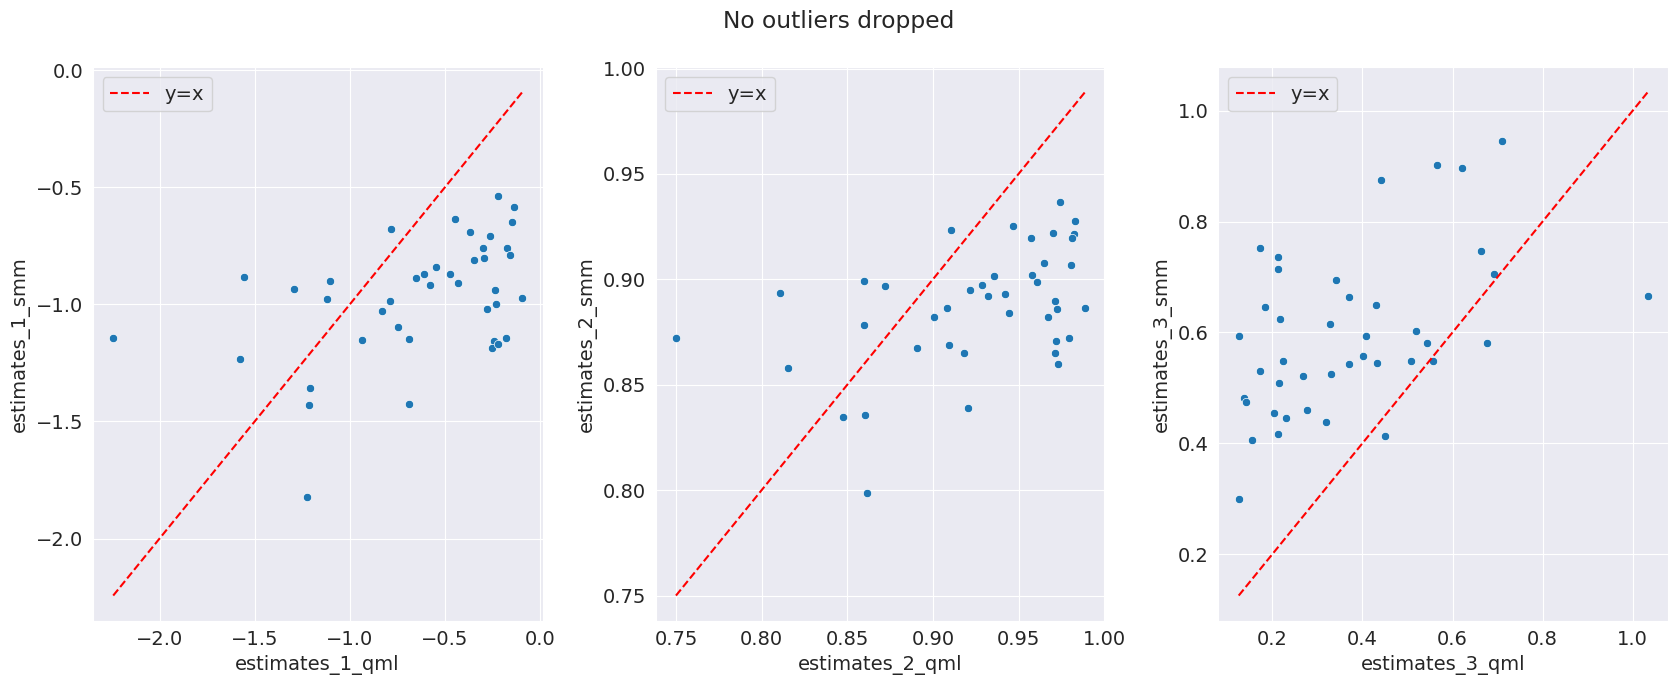

In [22]:
plot_qml_vs_smm_estimates(with_outliers, "No outliers dropped")

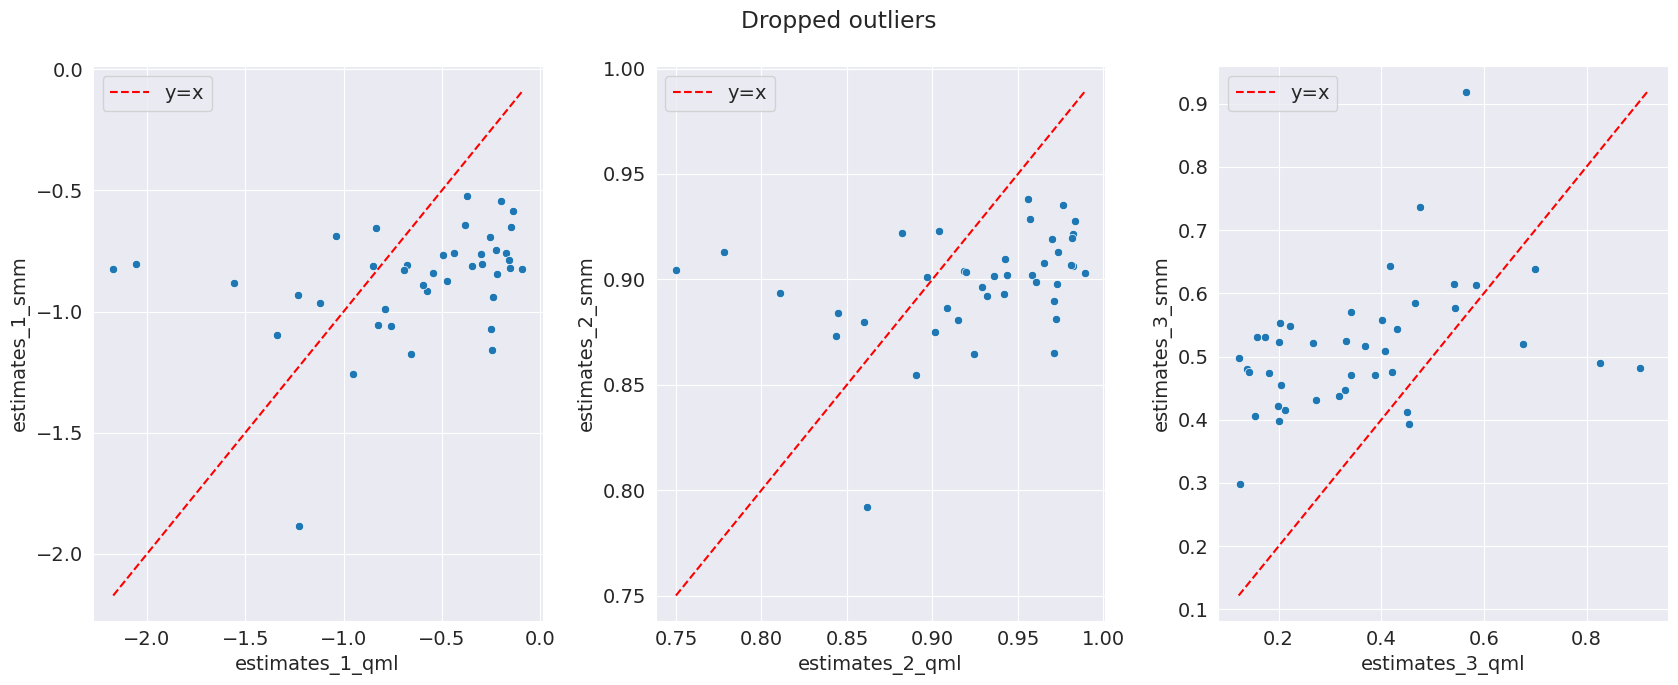

In [23]:
plot_qml_vs_smm_estimates(without_outliers, "Dropped outliers")

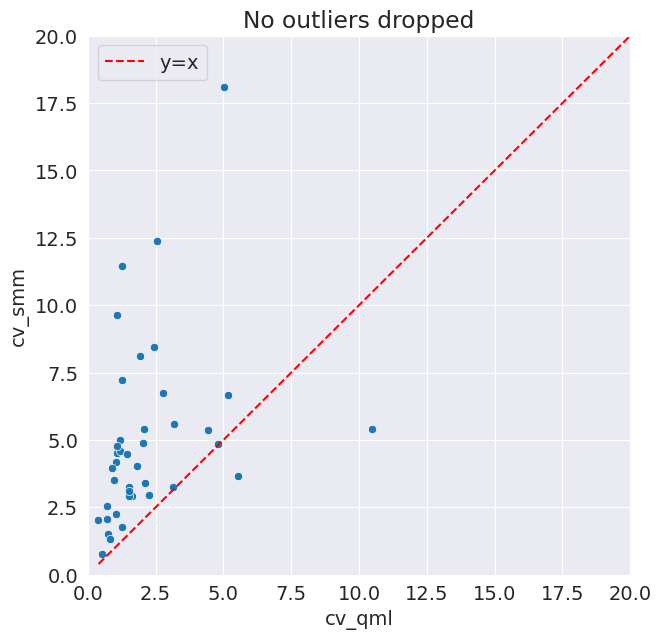

In [24]:
plot_qml_vs_smm_cv(with_outliers, "No outliers dropped", x_bounds=(0, 20), y_bounds=(0, 20))

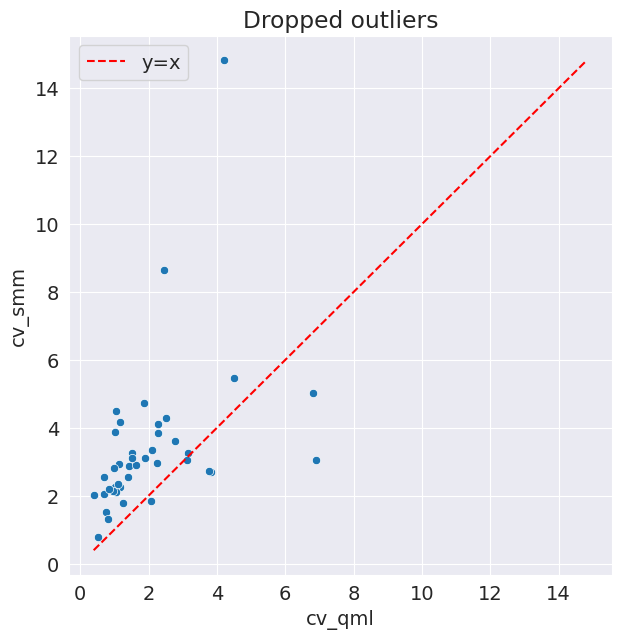

In [25]:
plot_qml_vs_smm_cv(without_outliers, "Dropped outliers")

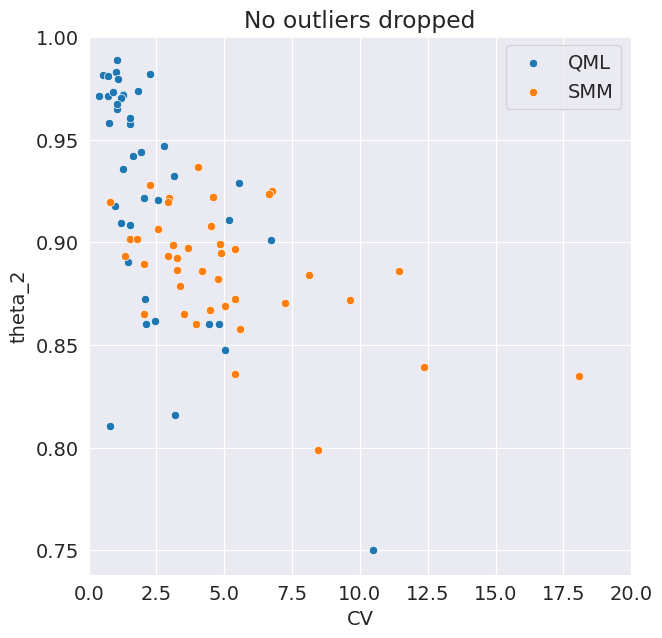

In [26]:
plot_cv_theta_two(qml_with_outliers, smm_with_outliers, "No outliers dropped", x_bounds=(0, 20))

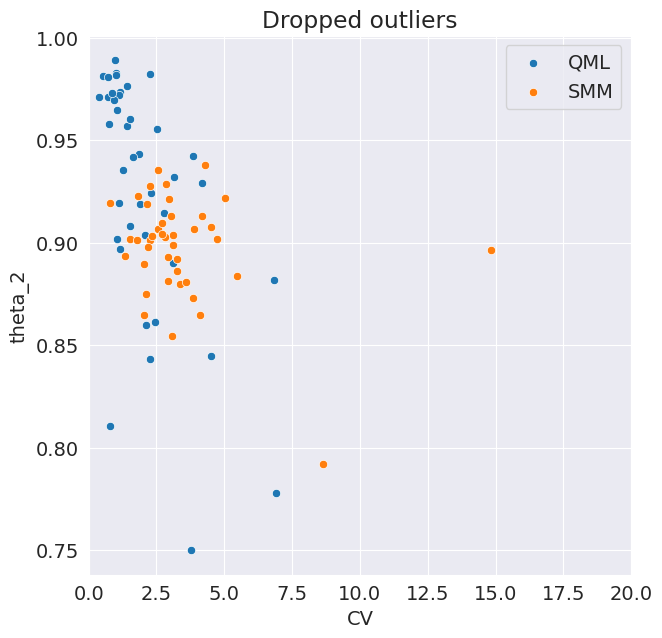

In [27]:
plot_cv_theta_two(qml_without_outliers, smm_without_outliers, "Dropped outliers", x_bounds=(0, 20))

In [28]:
pd.Series(determine_winner(without_outliers.winner_qml, without_outliers.winner_smm)).value_counts()


SMM    21
?      20
Name: count, dtype: int64

In [29]:
without_outliers["winner"] = determine_winner(without_outliers.winner_qml, without_outliers.winner_smm)
without_outliers

,estimates_1_qml,estimates_2_qml,estimates_3_qml,cv_qml,name_qml,size_qml,winner_qml,estimates_1_smm,estimates_2_smm,estimates_3_smm,cv_smm,name_smm,size_smm,winner_smm,winner
ticker,,,,,,,,,,,,,,,
AFKS,-0.848200,0.897031,0.388591,1.166354,qml_without_outliers,2323,SMM,-0.813689,0.901284,0.470587,2.254055,smm_without_outliers,2323,SMM,SMM
AFLT,-0.677685,0.918708,0.407844,1.904984,qml_without_outliers,2323,SMM,-0.807593,0.903855,0.509211,3.122934,smm_without_outliers,2323,SMM,SMM
AGRO,-0.577343,0.932188,0.431502,3.141461,qml_without_outliers,2298,SMM,-0.916565,0.892177,0.544191,3.269719,smm_without_outliers,2298,SMM,SMM
ALRS,-0.346496,0.958155,0.213216,0.741615,qml_without_outliers,2323,QML,-0.812531,0.901828,0.416201,1.528908,smm_without_outliers,2323,SMM,?
BSPB,-0.655392,0.924218,0.416618,2.288093,qml_without_outliers,2321,SMM,-1.172861,0.864563,0.642326,4.123254,smm_without_outliers,2321,SMM,SMM
CBOM,-0.173194,0.982202,0.204142,2.258565,qml_without_outliers,2203,QML,-0.759176,0.921572,0.455197,2.954672,smm_without_outliers,2203,SMM,?
CHMF,-0.239182,0.971257,0.137365,0.395178,qml_without_outliers,2323,QML,-0.939088,0.889566,0.480987,2.030319,smm_without_outliers,2323,SMM,?
ENPG,-1.118254,0.859984,0.543504,2.108926,qml_without_outliers,1031,SMM,-0.965947,0.879787,0.576755,3.358148,smm_without_outliers,1031,SMM,SMM
FEES,-0.370991,0.955771,0.330027,2.522398,qml_without_outliers,2309,QML,-0.522026,0.938173,0.446529,4.279961,smm_without_outliers,2309,SMM,?


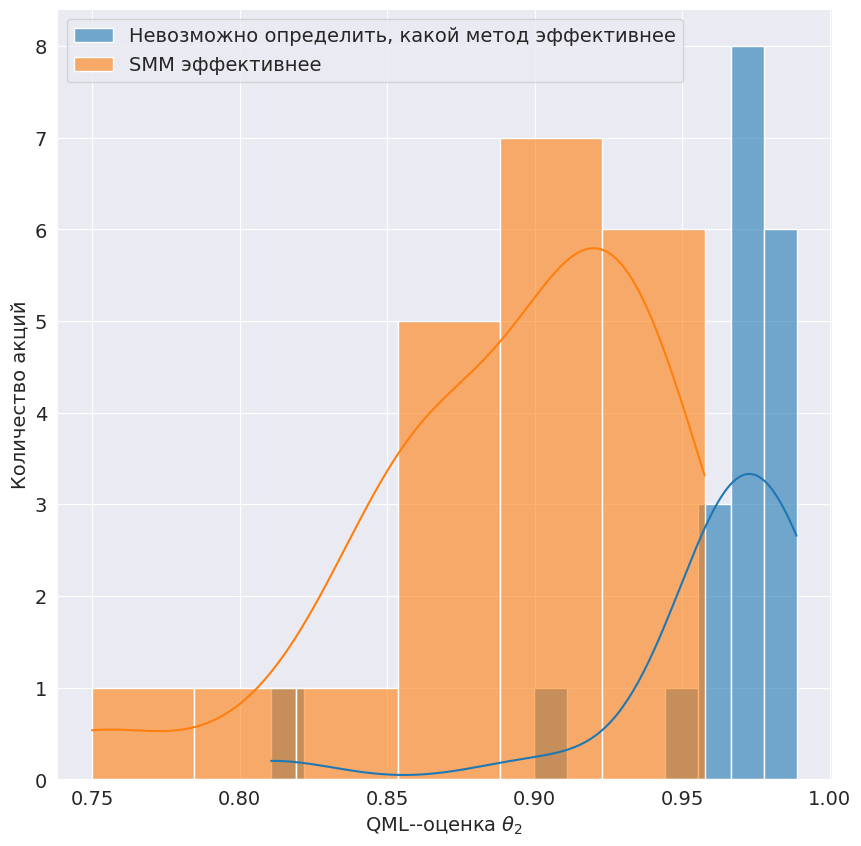

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=with_outliers[without_outliers.winner == "?"], x="estimates_2_qml", stat="count", label="Невозможно определить, какой метод эффективнее", alpha=0.6, kde=True)
sns.histplot(data=with_outliers[without_outliers.winner == "SMM"], x="estimates_2_qml", stat="count", label="SMM эффективнее", alpha=0.6, kde=True)

ax.set_xlabel(r'QML--оценка $\theta_2$')
ax.set_ylabel(r'Количество акций')

ax.legend()
plt.savefig("data/plots/theta_two_estimates.pdf", format="pdf");